### Overview: This EDA aims to understand the target "store_trans_filled" and conduct neccessary feature engineering for time series modeling. The goal is to predict daily store transactions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Read Full Table

In [2]:
df = pd.read_csv("filled_store_trans.csv")
# set the date column to datetime
df["date"]=pd.to_datetime(df["date"])
# set the "date" as index
df.set_index("date", inplace=True)
df.head()

,store_nbr,family,sales,onpromotion,store_promo,sto_type,cluster,holi_type,locale,description_eng,year,month,day,dcoilwtico_interpolated,store_trans_filled
date,,,,,,,,,,,,,,,
2013-01-02,1,BEVERAGES,1091.0,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
2013-01-02,1,CLEANING,1060.0,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
2013-01-02,1,DAIRY,579.0,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
2013-01-02,1,GROCERY I,2652.0,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
2013-01-02,1,PRODUCE,0.0,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0


In [3]:
df.shape

(143390, 15)

In [4]:
# drop category related and festival name columns 
df = df.drop(columns=["family","sales","onpromotion", "description_eng"])
df = df.drop_duplicates()
df

,store_nbr,store_promo,sto_type,cluster,holi_type,locale,year,month,day,dcoilwtico_interpolated,store_trans_filled
date,,,,,,,,,,,
2013-01-02,1,0,D,13,NaN,NaN,2013,1,2,93.14,2111.0
2013-01-02,10,0,C,15,NaN,NaN,2013,1,2,93.14,1293.0
2013-01-02,17,0,C,12,NaN,NaN,2013,1,2,93.14,1580.0
2013-01-02,2,0,D,13,NaN,NaN,2013,1,2,93.14,2358.0
2013-01-02,20,0,B,6,NaN,NaN,2013,1,2,93.14,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,49,168,A,11,NaN,NaN,2017,8,15,47.57,2814.0
2017-08-15,6,135,D,13,NaN,NaN,2017,8,15,47.57,1589.0
2017-08-15,7,130,D,8,NaN,NaN,2017,8,15,47.57,1780.0


In [5]:
# Drop data of store 18
df=df[df["store_nbr"]!= 18]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28662 entries, 2013-01-02 to 2017-08-15
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   store_nbr                28662 non-null  int64  
 1   store_promo              28662 non-null  int64  
 2   sto_type                 28662 non-null  object 
 3   cluster                  28662 non-null  int64  
 4   holi_type                2482 non-null   object 
 5   locale                   2482 non-null   object 
 6   year                     28662 non-null  int64  
 7   month                    28662 non-null  int64  
 8   day                      28662 non-null  int64  
 9   dcoilwtico_interpolated  28662 non-null  float64
 10  store_trans_filled       27891 non-null  float64
dtypes: float64(2), int64(6), object(3)
memory usage: 2.6+ MB


#### Check for the distributions of categorical data

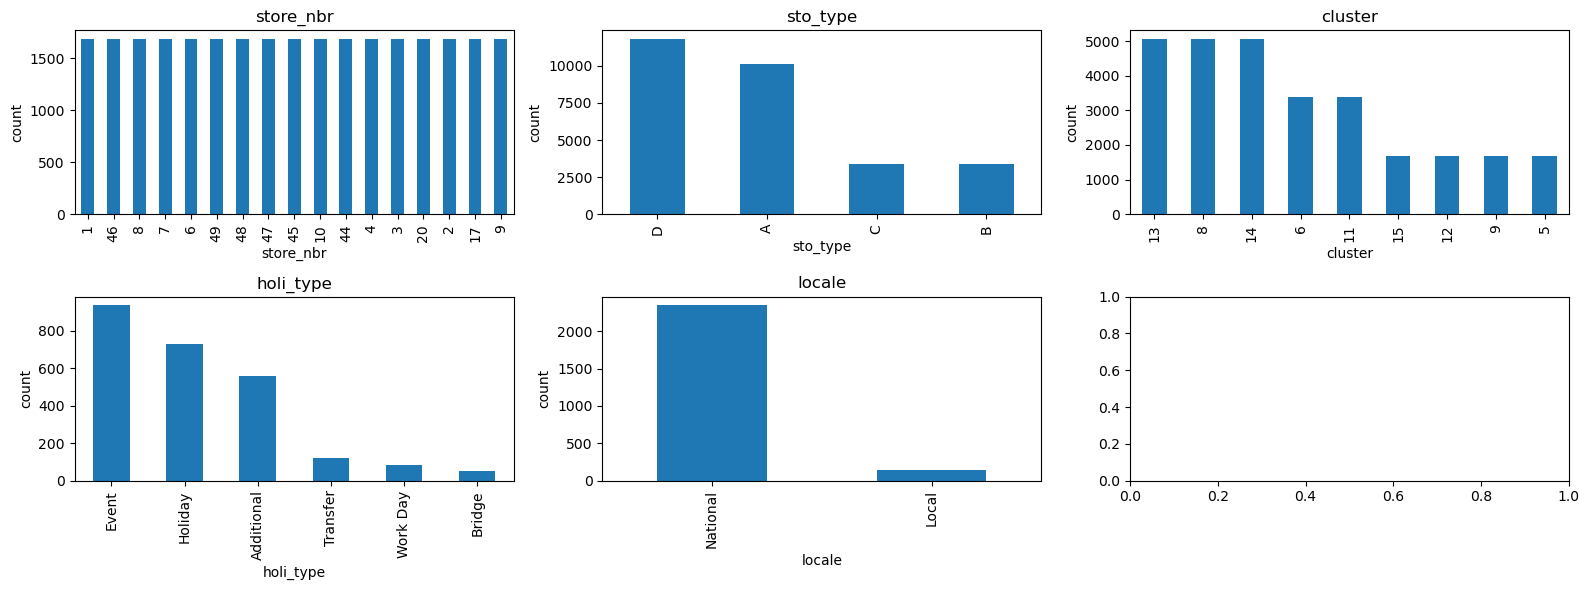

In [6]:
cols = ["store_nbr","sto_type","cluster","holi_type","locale"]
plt.subplots(2,3, figsize=(16,6))
for i, col in enumerate(cols):
    plt.subplot(2,3,i+1)
    df[col].value_counts().plot(kind="bar")
    plt.ylabel("count")
    plt.title(col)
plt.tight_layout()
plt.show()

#### Check for the Xs' relationships with the target: store_trans_filled

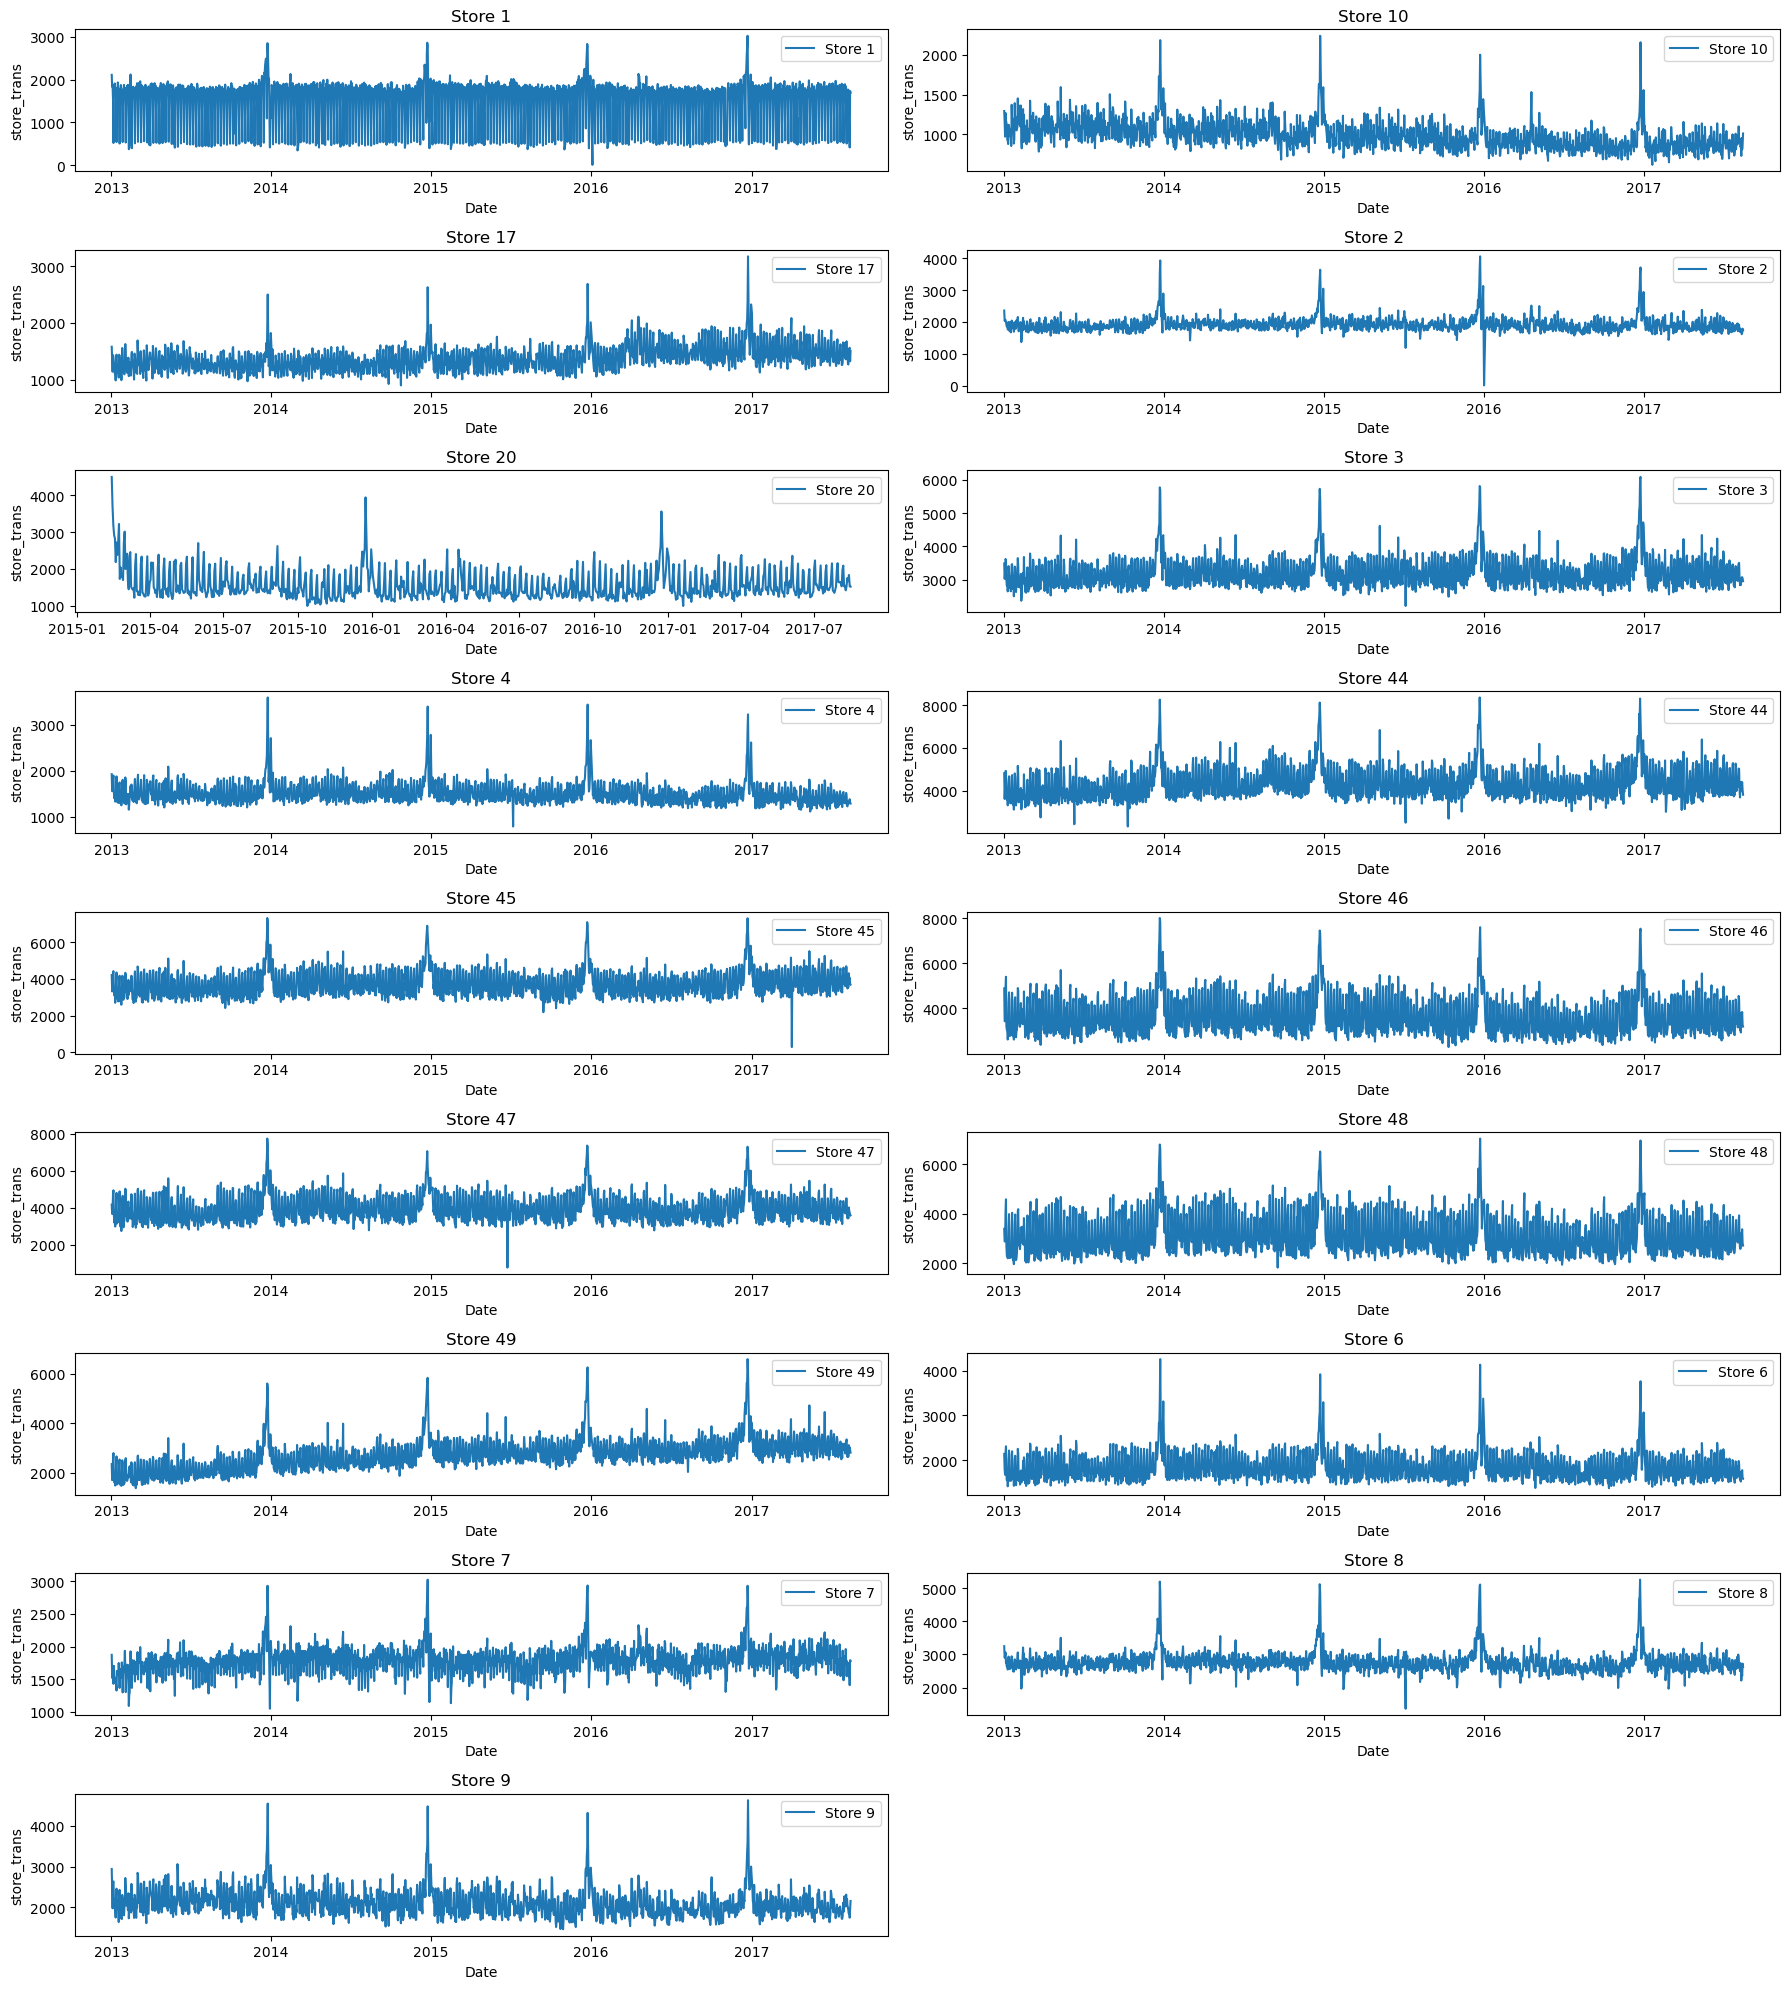

In [7]:
# check for the store number list
store_nbr_list = df["store_nbr"].drop_duplicates().tolist()
store_nbr_list
# Visualizing each store'sales
plt.figure(figsize=(18, 20))  # Adjusting figure size for better visualization

for i, store in enumerate(store_nbr_list):
    plt.subplot(9,2, i + 1)
    store_data = df[df["store_nbr"] == store]
    plt.plot(store_data.index, store_data["store_trans_filled"], label='Store ' + str(store))
    plt.title('Store ' + str(store))
    plt.xlabel('Date')
    plt.ylabel('store_trans')
    plt.legend()

plt.tight_layout()
plt.show()

##### We can see that there is a spike in store transactions at the end of each year across all stores. Both trends and seasonality are evident in the target variable, so we need to make the dataset stationary before modeling.

There are many nulls in holi_type column; to get the sales of the null category in the column, I need to fill the nulls with non_holi.

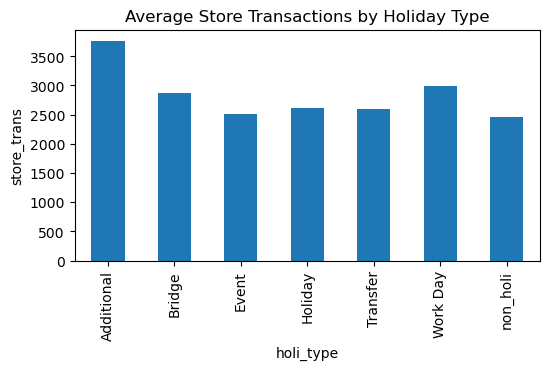

In [8]:
# check for avg sales by holiday
plt.figure(figsize=(6,3))
df['holi_type'].fillna('non_holi', inplace=True)
df.groupby(["holi_type"])["store_trans_filled"].mean().plot(kind="bar")
plt.ylabel("store_trans")
plt.title("Average Store Transactions by Holiday Type")
plt.show()

To avoid creating non_holi dummy variable, I will change the non_holi back to na

In [9]:
# change the non_holi back to NaN
df['holi_type'].replace('non_holi', np.nan, inplace=True)

In [10]:
# change the categorical columns from numbers to string
df["store_nbr"] = df["store_nbr"].astype(str)
df["cluster"] = df["cluster"].astype(str)
# sanity check
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28662 entries, 2013-01-02 to 2017-08-15
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   store_nbr                28662 non-null  object 
 1   store_promo              28662 non-null  int64  
 2   sto_type                 28662 non-null  object 
 3   cluster                  28662 non-null  object 
 4   holi_type                2482 non-null   object 
 5   locale                   2482 non-null   object 
 6   year                     28662 non-null  int64  
 7   month                    28662 non-null  int64  
 8   day                      28662 non-null  int64  
 9   dcoilwtico_interpolated  28662 non-null  float64
 10  store_trans_filled       27891 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 2.6+ MB


#### Feature engineering of date

In [11]:
df.reset_index(inplace=True)
df["weekday"]=np.where(df["date"].dt.weekday<5,df["date"].dt.weekday+1,0)
df["weekend"]=np.where(df["date"].dt.weekday>=5,1,0)
df.head(3)

,date,store_nbr,store_promo,sto_type,cluster,holi_type,locale,year,month,day,dcoilwtico_interpolated,store_trans_filled,weekday,weekend
0,2013-01-02,1,0,D,13,NaN,NaN,2013,1,2,93.14,2111.0,3,0
1,2013-01-02,10,0,C,15,NaN,NaN,2013,1,2,93.14,1293.0,3,0
2,2013-01-02,17,0,C,12,NaN,NaN,2013,1,2,93.14,1580.0,3,0


In [12]:
df_store_trans_final = df
df_store_trans_final.to_csv("full_store_trans.csv",index=False)